<a id="3"></a>
## **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#1991ee;font-size:120%;font-family:Verdana;"><center><span> Import Libraries </span></center></div>**

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
import pandas as pd

<a id="3"></a>
## **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#1991ee;font-size:120%;font-family:Verdana;"><center><span> 1. Spark Session </span></center></div>**

In [2]:
spark = SparkSession.builder.appName("WalmartDemandForecastingWeeklySalesPrediction").getOrCreate()

<a id="3"></a>
## **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#1991ee;font-size:120%;font-family:Verdana;"><center><span>2. Data Reading </span></center></div>**

In [3]:
features_df = spark.read.csv("features.csv", header=True, inferSchema=True)
stores_df = spark.read.csv("stores.csv", header=True, inferSchema=True)
train_df = spark.read.csv("train.csv", header=True, inferSchema=True)
test_df = spark.read.csv("test.csv", header=True, inferSchema=True)

<a id="3"></a>
## **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#1991ee;font-size:120%;font-family:Verdana;"><center><span>3. Exploratory Data Analysis </span></center></div>**

In [4]:
sample_pd = train_df.sample(False, 0.05, seed=42).toPandas()

<a id="3"></a>
#### **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#1991ee;font-size:120%;font-family:Verdana;"><center><span>Histogram: Weekly Sales Distribution </span></center></div>**

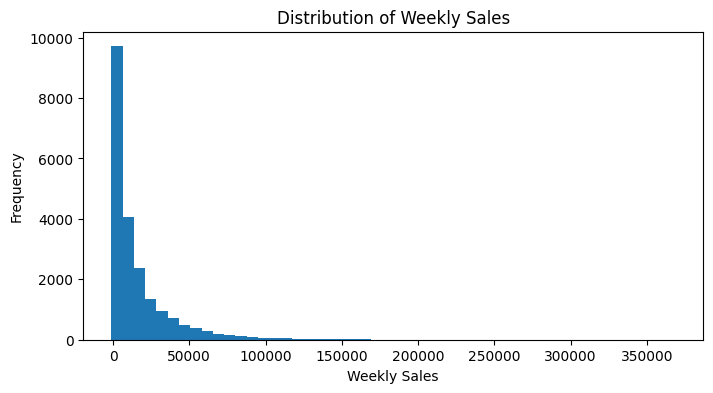

In [5]:
plt.figure(figsize=(8,4))
plt.hist(sample_pd["Weekly_Sales"], bins=50)
plt.title("Distribution of Weekly Sales")
plt.xlabel("Weekly Sales")
plt.ylabel("Frequency")
plt.show()

<a id="3"></a>
#### **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#1991ee;font-size:120%;font-family:Verdana;"><center><span>Scatter Plot: IsHoliday vs Weekly Sales </span></center></div>**

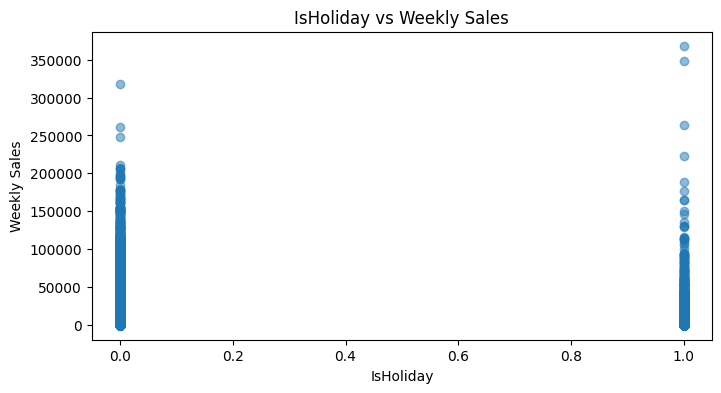

In [6]:
plt.figure(figsize=(8,4))
plt.scatter(sample_pd["IsHoliday"], sample_pd["Weekly_Sales"], alpha=0.5)
plt.title("IsHoliday vs Weekly Sales")
plt.xlabel("IsHoliday")
plt.ylabel("Weekly Sales")
plt.show()

<a id="3"></a>
#### **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#1991ee;font-size:120%;font-family:Verdana;"><center><span>Boxplot: Weekly Sales by Store</span></center></div>**

<Figure size 800x400 with 0 Axes>

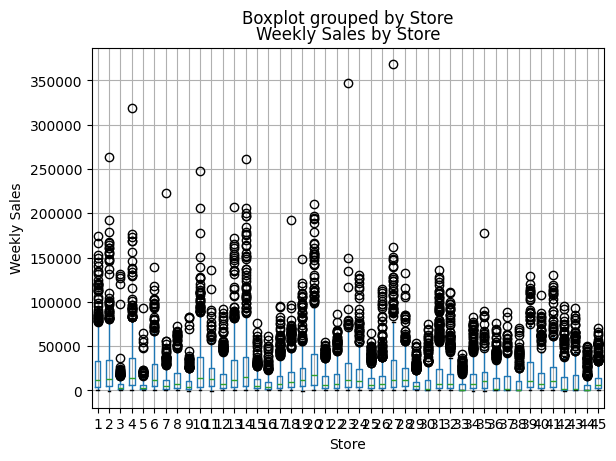

In [7]:
plt.figure(figsize=(8,4))
sample_pd.boxplot(column="Weekly_Sales", by="Store")
plt.title("Boxplot grouped by Store")
plt.suptitle("Weekly Sales by Store")
plt.xlabel("Store")
plt.ylabel("Weekly Sales")
plt.show()

<a id="3"></a>
#### **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#1991ee;font-size:120%;font-family:Verdana;"><center><span>Line Plot: Average Weekly Sales Over Time </span></center></div>**

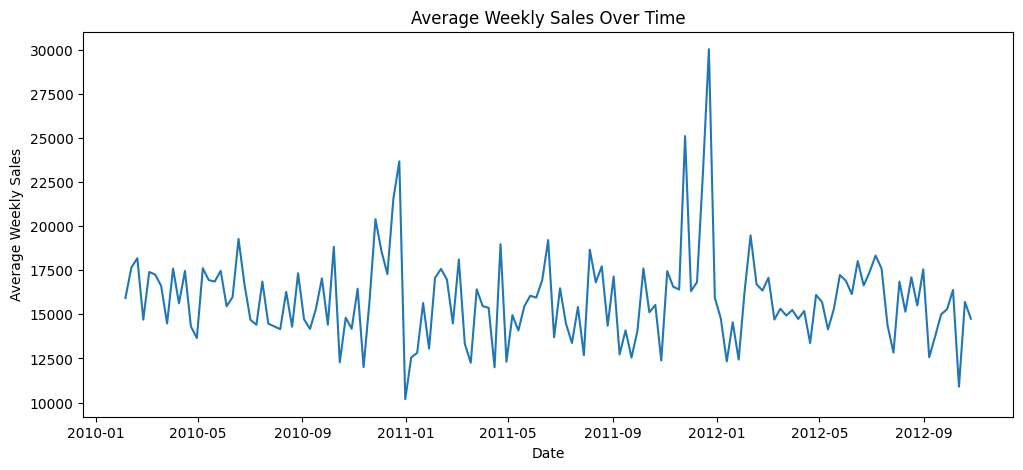

In [8]:
# Ensure Date is datetime
sample_pd["Date"] = pd.to_datetime(sample_pd["Date"])
# Group by date and compute average weekly sales
avg_sales_by_date = sample_pd.groupby("Date")["Weekly_Sales"].mean().reset_index()

plt.figure(figsize=(12,5))
plt.plot(avg_sales_by_date["Date"], avg_sales_by_date["Weekly_Sales"])
plt.title("Average Weekly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Average Weekly Sales")
plt.show()

<a id="3"></a>
## **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#1991ee;font-size:120%;font-family:Verdana;"><center><span>4. Data Merging </span></center></div>**

In [9]:
train_full = train_df.join(features_df, on=['Store', 'Date', 'IsHoliday'], how='left')
train_full = train_full.join(stores_df, on='Store', how='left')
test_full = test_df.join(features_df, on=['Store', 'Date', 'IsHoliday'], how='left')
test_full = test_full.join(stores_df, on='Store', how='left')

<a id="3"></a>
## **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#1991ee;font-size:120%;font-family:Verdana;"><center><span>5. Data Cleaning (fill NA for markdowns, drop other NAs) </span></center></div>**

In [10]:
markdown_cols = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
for col in markdown_cols:
    train_full = train_full.na.fill({col: 0})
    test_full = test_full.na.fill({col: 0})
train_full = train_full.dropna()
test_full = test_full.dropna()

In [11]:
# The type is boolean and we are doing tyecasting because Pyspark 
# StringIndexer wants value that is string or numeric not boolean
train_full = train_full.withColumn("IsHoliday_str", train_full["IsHoliday"].cast("string"))
test_full = test_full.withColumn("IsHoliday_str", test_full["IsHoliday"].cast("string"))

<a id="3"></a>
## **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#1991ee;font-size:120%;font-family:Verdana;"><center><span>6. Feature Engineering</span></center></div>**

In [12]:
# Cast all numeric columns to double (float)
numeric_cols = [
    'Store', 'Dept', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
    'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size'
]

for col_name in numeric_cols:
    train_full = train_full.withColumn(col_name, train_full[col_name].cast("double"))
    test_full = test_full.withColumn(col_name, test_full[col_name].cast("double"))

<a id="3"></a>
## **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#1991ee;font-size:120%;font-family:Verdana;"><center><span>7. Encoding</span></center></div>**

In [13]:
# Encode 'Type'
indexer1 = StringIndexer(inputCol="Type", outputCol="Type_indexed")
# Encode 'IsHoliday_str'
indexer2 = StringIndexer(inputCol="IsHoliday_str", outputCol="IsHoliday_indexed")

In [14]:
# 3. Apply encoded indexers
train_full = indexer1.fit(train_full).transform(train_full)
train_full = indexer2.fit(train_full).transform(train_full)
test_full = indexer1.fit(test_full).transform(test_full)
test_full = indexer2.fit(test_full).transform(test_full)

In [15]:
# selecting columns for the vector assembler
feature_cols = [
    'Store', 'Dept', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
    'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
    'Size', 'Type_indexed', 'IsHoliday_indexed'
]

In [16]:
# Remove rows with nulls in feature columns and label
train_full = train_full.dropna(subset=feature_cols + ["Weekly_Sales"])
test_full = test_full.dropna(subset=feature_cols)

In [17]:
# this step will make all the feature_cols column into one column features for Machine Learning model
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_full = assembler.transform(train_full)
test_full = assembler.transform(test_full)

<a id="3"></a>
## **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#1991ee;font-size:120%;font-family:Verdana;"><center><span>8. Train/Test Split</span></center></div>**

In [18]:
train_data, val_data = train_full.randomSplit([0.8, 0.2], seed=42)

<a id="3"></a>
## **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#1991ee;font-size:120%;font-family:Verdana;"><center><span>9. Modeling </span></center></div>**

<a id="3"></a>
#### **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#1991ee;font-size:120%;font-family:Verdana;"><center><span>Random Forest Regressor Modeling </span></center></div>**

In [20]:
rf = RandomForestRegressor(featuresCol="features", labelCol="Weekly_Sales")
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(val_data)

rf_evaluator = RegressionEvaluator(labelCol="Weekly_Sales", predictionCol="prediction", metricName="rmse")
rf_rmse = rf_evaluator.evaluate(rf_predictions)
rf_r2 = RegressionEvaluator(labelCol="Weekly_Sales", predictionCol="prediction", metricName="r2").evaluate(rf_predictions)
rf_mae = RegressionEvaluator(labelCol="Weekly_Sales", predictionCol="prediction", metricName="mae").evaluate(rf_predictions)
print(f"Random Forest Regressor Validation RMSE: {rf_rmse:.2f}")
print(f"Random Forest Regressor R2: {rf_r2:.2f}")
print(f"Random Forest Regressor MAE: {rf_mae:.2f}")

Random Forest Regressor Validation RMSE: 18977.21
Random Forest Regressor R2: 0.39
Random Forest Regressor MAE: 12559.85


<a id="3"></a>
#### **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#1991ee;font-size:120%;font-family:Verdana;"><center><span>Linear Regression Modeling</span></center></div>**

In [21]:
lr = LinearRegression(featuresCol="features", labelCol="Weekly_Sales")
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(val_data)

lr_evaluator = RegressionEvaluator(labelCol="Weekly_Sales", predictionCol="prediction", metricName="rmse")
lr_rmse = lr_evaluator.evaluate(lr_predictions)
lr_r2 = RegressionEvaluator(labelCol="Weekly_Sales", predictionCol="prediction", metricName="r2").evaluate(lr_predictions)
lr_mae = RegressionEvaluator(labelCol="Weekly_Sales", predictionCol="prediction", metricName="mae").evaluate(lr_predictions)
print(f"Linear Regression Validation RMSE: {lr_rmse:.2f}")
print(f"Linear Regression R2: {lr_r2:.2f}")
print(f"Linear Regression MAE: {lr_mae:.2f}")

Linear Regression Validation RMSE: 23374.97
Linear Regression R2: 0.07
Linear Regression MAE: 15918.94


<a id="3"></a>
## **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#1991ee;font-size:120%;font-family:Verdana;"><center><span>Predictions & Evaluation</span></center></div>**

In [22]:
print("Random Forest Predictions on Test Set:")
rf_test_predictions = rf_model.transform(test_full)
rf_test_predictions.select("Store", "Dept", "Date", "prediction").show(10)

print("Linear Regression Predictions on Test Set:")
lr_test_predictions = lr_model.transform(test_full)
lr_test_predictions.select("Store", "Dept", "Date", "prediction").show(10)

Random Forest Predictions on Test Set:
+-----+----+----------+------------------+
|Store|Dept|      Date|        prediction|
+-----+----+----------+------------------+
|  1.0| 1.0|2012-11-02|21112.387011565617|
|  1.0| 1.0|2012-11-09|23008.207435599874|
|  1.0| 1.0|2012-11-16|23669.097383160493|
|  1.0| 1.0|2012-11-23|29063.448082993757|
|  1.0| 1.0|2012-12-28|22340.314350563065|
|  1.0| 1.0|2013-01-04| 23900.19110852213|
|  1.0| 1.0|2013-01-11|  22309.3755527437|
|  1.0| 1.0|2013-01-18|20980.592520146274|
|  1.0| 1.0|2013-01-25|20818.484392205708|
|  1.0| 1.0|2013-02-01| 22592.46137185187|
+-----+----+----------+------------------+
only showing top 10 rows

Linear Regression Predictions on Test Set:
+-----+----+----------+------------------+
|Store|Dept|      Date|        prediction|
+-----+----+----------+------------------+
|  1.0| 1.0|2012-11-02|13575.492073347012|
|  1.0| 1.0|2012-11-09|14110.417700232523|
|  1.0| 1.0|2012-11-16|14411.959021179886|
|  1.0| 1.0|2012-11-23| 23156.85

## **Conclusion:**
Random Forest Regressor performed significantly better than Linear Regression for this problem. It had a lower RMSE and MAE, and a much higher R² score, indicating better predictive accuracy and a stronger fit to the data.